# Практическая работа №4
## Тема: Деревья решений
Выполнила Фонград Анастасия КИ21-16/1б

In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image, display
import pydotplus
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore")

In [20]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_3.csv")

## Предварительная обработка данных
Произведём пред обработку данных для задачи классификации

In [21]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [22]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 81071 to 179814
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Произведём пред обработку данных для задачи регрессии

In [23]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

Произведём сэмплирование данных для задачи классификации

In [24]:
def build_response_graph(column):
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

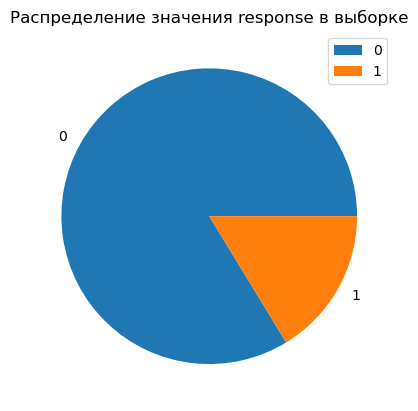

In [25]:
build_response_graph(class_train[class_result])

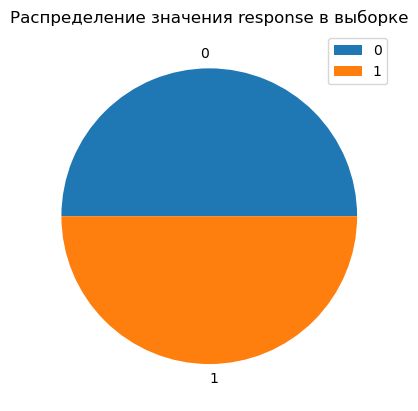

In [26]:
x = class_train[class_all]
y = class_train[class_result]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [27]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение деревьев решений

In [94]:
def test_class_parameters(parameters, parameter_name):
    """
    Отбирает лучшие параметры модели классификации
    :param parameters: список тестируемых параметров
    :param parameter_name: название тестируемого параметра
    :return: Модель с лучшими параметрами
    """
    train_acc = []
    test_acc = []
    cross_val_acc = []
    clfs = []
    for parameter in parameters:
        if parameter_name == "Max depth":
            clf = DecisionTreeClassifier(max_depth=parameter)
        elif parameter_name == "Ccp alpha":
            clf = DecisionTreeClassifier(ccp_alpha=parameter)
        elif parameter_name == "Min samples split":
            clf = DecisionTreeClassifier(min_samples_split=parameter)
        elif parameter_name == "Criterion":
            clf = DecisionTreeClassifier(criterion=parameter)
        elif parameter_name == "Min samples leaf":
            clf = DecisionTreeClassifier(min_samples_leaf=parameter)
        elif parameter_name == "Criterion":
            clf = DecisionTreeClassifier(criterion=parameter)
        elif parameter_name == "Max leaf nodes":
            clf = DecisionTreeClassifier(max_leaf_nodes=parameter)
        clfs.append(clf)
        clf.fit(x_train_c, y_train_c)
        y_pred_train = clf.predict(x_train_c)
        y_pred_test = clf.predict(x_test_c)
        train_acc.append(accuracy_score(y_train_c, y_pred_train))
        test_acc.append(accuracy_score(y_test_c, y_pred_test))
        cr = cross_val_score(clf, class_train[class_all], class_train[class_result])[0]
        cross_val_acc.append(cr)
    best_index = test_acc.index(max(test_acc))
    best_clf = clfs[best_index]
    print(f"The best model: {best_clf}")
    print("Accuracy:", round(test_acc[best_index], 3))
    if parameter_name != "Criterion":
        plot_accuracy_graph(parameters, parameter_name, train_acc, test_acc, cross_val_acc)
    else:
        plot_criteria(parameters, train_acc, test_acc, cross_val_acc)
    return best_clf

In [95]:
def test_regression_parameters(parameters, parameter_name):
    """
    Отбирает лучшие параметры модели регрессии
    :param parameters: список тестируемых параметров
    :param parameter_name: название тестируемого параметра
    :return: Модель с лучшими параметрами
    """
    train_acc = []
    test_acc = []
    clfs = []
    for parameter in parameters:
        if parameter_name == "Max depth":
            clf = DecisionTreeRegressor(max_depth=parameter)
        elif parameter_name == "Ccp alpha":
            clf = DecisionTreeRegressor(ccp_alpha=parameter)
        elif parameter_name == "Min samples split":
            clf = DecisionTreeRegressor(min_samples_split=parameter)
        elif parameter_name == "Min samples leaf":
            clf = DecisionTreeRegressor(min_samples_leaf=parameter)
        elif parameter_name == "Criterion":
            clf = DecisionTreeRegressor(criterion=parameter)
        elif parameter_name == "Max leaf nodes":
            clf = DecisionTreeRegressor(max_leaf_nodes=parameter)
        clfs.append(clf)
        clf.fit(x_train_r, y_train_r)
        train_acc.append(clf.score(x_train_r, y_train_r))
        test_acc.append(clf.score(x_test_r, y_test_r))
    best_index = test_acc.index(max(test_acc))
    best_clf = clfs[best_index]
    print(f"The best model: {best_clf}")
    print("R^2:", round(test_acc[best_index], 3))
    if parameter_name != "Criterion":
        plot_accuracy_graph(parameters, parameter_name, train_acc, test_acc, regression=True)
    else:
        plot_criteria(parameters, train_acc, test_acc)
    return best_clf

In [96]:
def plot_criteria(parameters, train_acc, test_acc, cross_acc=None):
    """
    Выводит столбчатую диаграмму критериев
    :param parameters:
    :param train_acc:
    :param test_acc:
    :param cross_acc:
    :return:
    """
    plt.bar(parameters, train_acc, label="train")
    plt.bar(parameters, test_acc, label="test")
    if cross_acc:
        plt.bar(parameters, cross_acc, label="cross validation")
    plt.legend()
    plt.show()

In [97]:
def plot_tree_image(data, features, file_name):
    """
    Визуализирует дерево и сохраняет его в виде изображения
    :param data: модель для визуализации
    :param features: набор признаков для визуализации
    :param file_name: название файла для сохранения
    """
    dot_data = StringIO()
    export_graphviz(data, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(file_name)
    img = Image(graph.create_png())
    display(img)

In [98]:
def plot_accuracy_graph(parameters, parameter_name, train_acc, test_acc,
                        cross_acc=None, regression=False):
    """
    Строит график зависимости точности от параметров модели
    :param parameters: список параметров
    :param parameter_name: название исследуемого параметра
    :param train_acc: производительность на тренировочной выборке
    :param test_acc: производительность на тестовой выборке
    :param cross_acc: производительность при перекрёстной проверке
    :param regression: используем ли модель регрессии
    """
    plt.plot(parameters, train_acc, label="Train")
    plt.plot(parameters, test_acc, label="Test")
    if cross_acc:
        plt.plot(parameters, cross_acc, label="Cross validation")
    plt.xlabel(parameter_name)
    if not regression:
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs {parameter_name}")
    else:
        plt.ylabel("R^2")
        plt.title(f"R^2 vs {parameter_name}")
    plt.legend()
    plt.show()

### Классификация
Исследуем зависимость между высотой и предсказательной способностью дерева

The best model: DecisionTreeClassifier(criterion='entropy')
Accuracy: 0.886


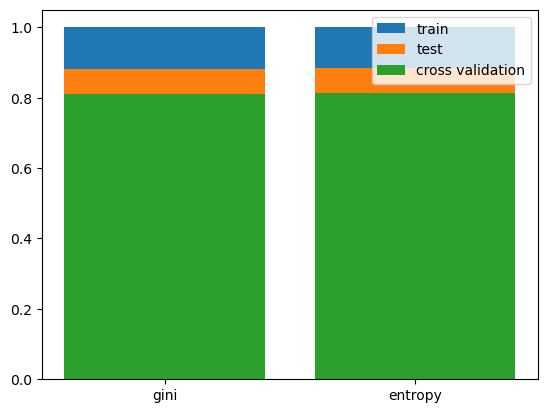

In [99]:
criterion = ["gini", "entropy"]
model = test_class_parameters(criterion, "Criterion")

The best model: DecisionTreeClassifier(max_leaf_nodes=38)
Accuracy: 0.9


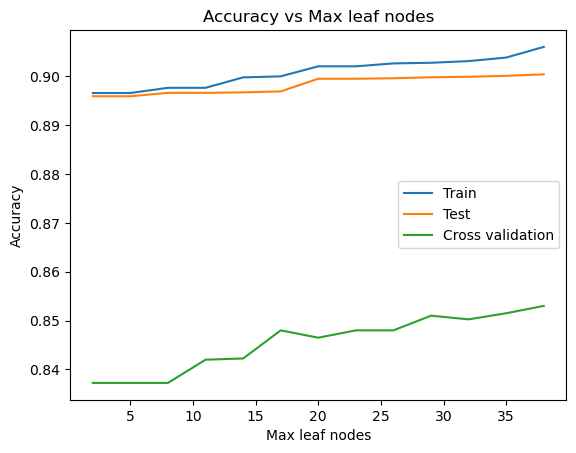

In [103]:
max_leaf_nodes = range(2, 40, 3)
model = test_class_parameters(max_leaf_nodes, "Max leaf nodes")

The best model: DecisionTreeClassifier(max_depth=8)
Accuracy: 0.899


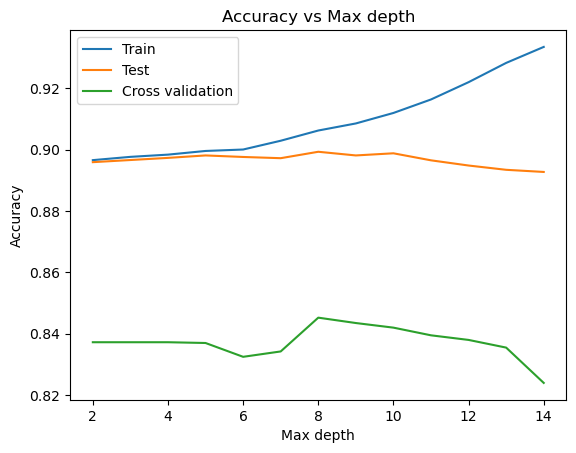

In [111]:
max_depth_list = range(2, 15)
model = test_class_parameters(max_depth_list, "Max depth")

The best model: DecisionTreeClassifier(min_samples_split=41)
Accuracy: 0.893


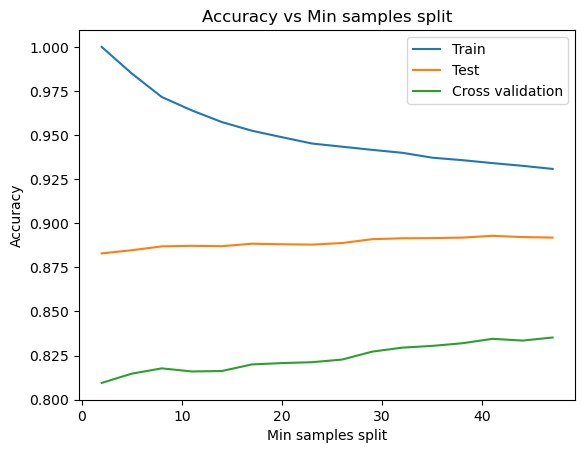

In [109]:
min_samples_split = range(2, 50, 3)
model = test_class_parameters(min_samples_split, "Min samples split")

The best model: DecisionTreeClassifier(min_samples_leaf=41)
Accuracy: 0.902


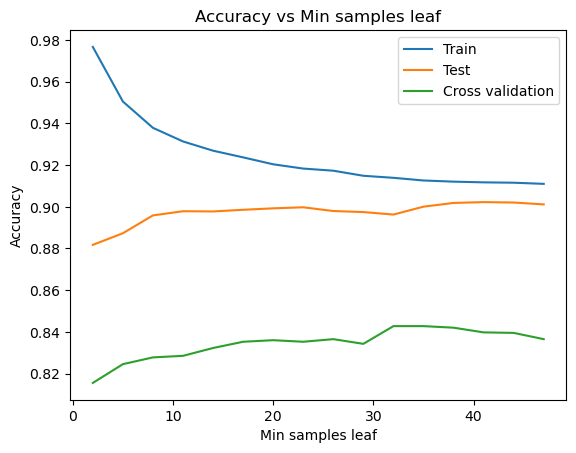

In [110]:
min_samples_leaf = range(2, 50, 3)
model = test_class_parameters(min_samples_leaf, "Min samples leaf")

Построим дерево с наилучшими параметрами

In [ ]:
plot_tree_image(model, class_all, "class_tree.png")

### Регрессия
Определим зависимость качества прогнозирования от высоты дерева

The best model: DecisionTreeRegressor(criterion='absolute_error')
R^2: 0.818
2


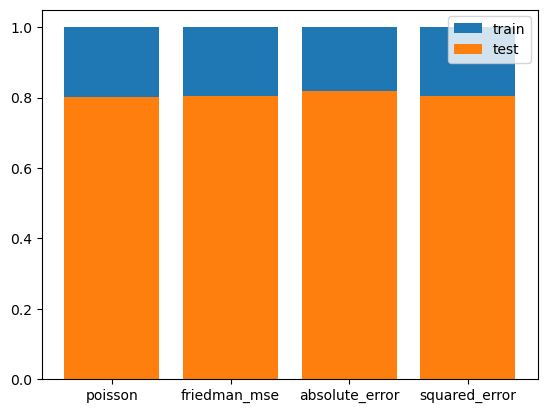

In [79]:
criterion = ["poisson", "friedman_mse", "absolute_error", "squared_error"]
model = test_regression_parameters(criterion, "Criterion")

The best model: DecisionTreeRegressor(max_leaf_nodes=26)
R^2: 0.856
1


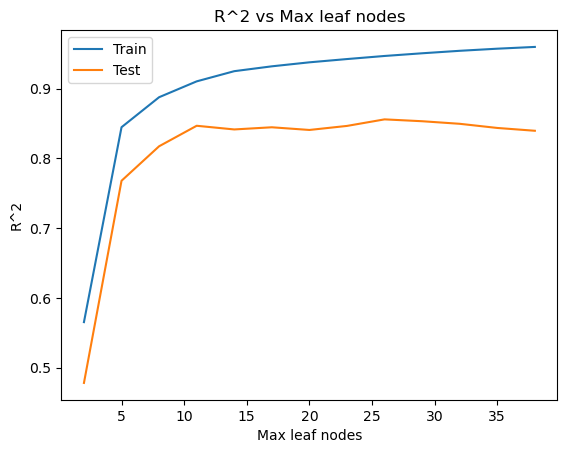

In [104]:
max_leaf_nodes = range(2, 40, 3)
model = test_regression_parameters(max_leaf_nodes, "Max leaf nodes")

The best model: DecisionTreeRegressor(max_depth=4)
R^2: 0.844
1


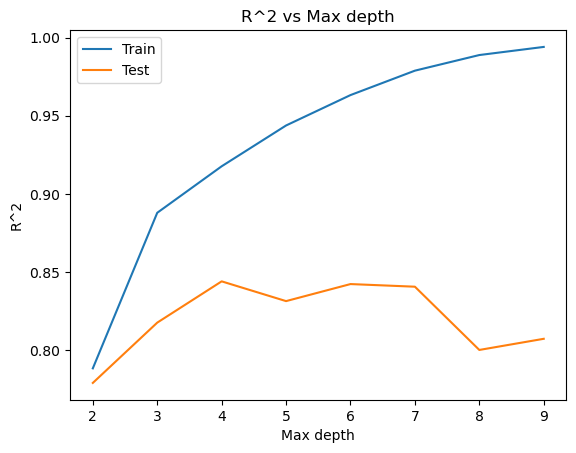

In [80]:
max_depth_list = range(2, 10)
model = test_regression_parameters(max_depth_list, "Max depth")

The best model: DecisionTreeRegressor(min_samples_split=26)
R^2: 0.852
1


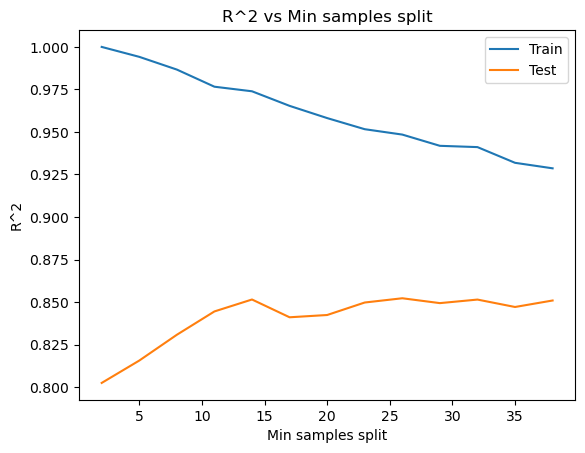

In [105]:
min_samples_split = range(2, 40, 3)
model = test_regression_parameters(min_samples_split, "Min samples split")

The best model: DecisionTreeRegressor(min_samples_leaf=32)
R^2: 0.882
1


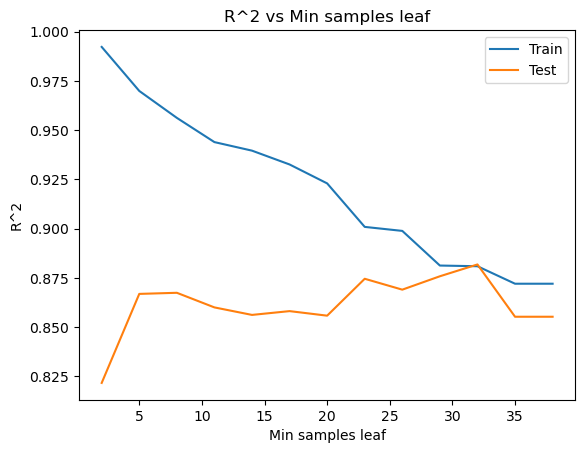

In [106]:
min_samples_leaf = range(2, 40, 3)
model = test_regression_parameters(min_samples_leaf, "Min samples leaf")

Построим дерево с наилучшими параметрами

In [ ]:
plot_tree_image(model, regression_all, "regression_tree.png")

## Обрезка деревьев
### Классификация
Выберем лучшее значение ccp_alphas

In [ ]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_c, y_train_c)
ccp_alphas = path.ccp_alphas
model = test_class_parameters(ccp_alphas, 0)

Построим обрезанное дерево

In [ ]:
plot_tree_image(model, class_all, "new_class.png")

### Регрессия
Выберем лучшее значение ccp_alphas

In [ ]:
dt = DecisionTreeRegressor(max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_r, y_train_r)
ccp_alphas = path.ccp_alphas
model = test_regression_parameters(ccp_alphas, 0)

Построим обрезанное дерево

In [ ]:
plot_tree_image(model, regression_all, "new_regression.png")

Можно увидеть, что обрезка дерева приводит к увеличению score для тестовой выборки

## Сравнение результатов
Скопируем данные из прошлых практических работ

In [ ]:
class_models =  pd.DataFrame(
    {
        "Model name": ["LogisticRegression", "KNeighborsClassifier", "GaussianNB", "LinearDiscriminantAnalysis",
                         "QuadraticDiscriminantAnalysis", "SVC"],
        "Score": [0.923, 0.951, 0.938, 0.922, 0.937, 0.929],
    }
)

In [ ]:
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", "Elastic-Net", "Метод наименьших углов",
                       "Байесовская регрессия", "Обобщённая линейная регрессия", "Взвешенный МНК", "Полиномиальная регрессия",
                       "Непараметрическая регрессия", "Ядерная регрессия"],
        "R^2": [0.892566, 0.891590, 0.891587, 0.885632, 0.892566, 0.891779, 0.874363, 0.875718, 0.893461, 0.716178, 0.897392],
    }
)

Добавим результаты, полученные с помощью деревьев решений

Построим столбчатые диаграммы

In [ ]:
def plot_bar_graph(ax, names, scoring, title):
    """
    Строит столбчатую диаграмму для score моделей
    :param ax: ось, на которой строим график
    """
    ax.bar(names, scoring)
    ax.set_title(title)
    ax.tick_params("x", labelrotation=90)
    ax.set_ylim((0.5, 1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Model", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

In [ ]:
def compare_models():
    """
    Выводит графики для сравнения моделей
    @:return:
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_bar_graph(axs[0], regression_models["Model name"], regression_models["R^2"], "Regression")
    plot_bar_graph(axs[1], class_models["Model name"], class_models["Score"], "Classification")

In [ ]:
compare_models()